# Analisis de Ventas - Proyecto RSM

- Media
- Mediana
- Deviacion Estandar
- Numero de transacciones


### Importaciones de librerias


In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import numpy as np

# Cadena de conexion a la base de datos

### PostgreSQL

```python
from sqlalchemy import create_engine
# Conexion a la base de datos
DATABASE = "db"
USER = "db_user"
PASSWORD = "DB_PASSWORD"
HOST = "db_host"
PORT = "db_port"
engine = create_engine(f"postgresql://{USER}:{PASSWORD}@{HOST}:{PORT}/{DATABASE}")
```

In [24]:
# Leer las tablas de la base de datos
from sqlalchemy import create_engine

DATABASE = "db_final"
USER = "postgres"
PASSWORD = "123456"
HOST = "localhost"
PORT = "5432"
engine = create_engine(f"postgresql://{USER}:{PASSWORD}@{HOST}:{PORT}/{DATABASE}")
# Lectura de datos desde SQL
df_clientes = pd.read_sql_table("clientes", con=engine)
df_productos = pd.read_sql_table("productos", con=engine)
df_transacciones = pd.read_sql_table("transacciones", con=engine)
df_ventas = pd.read_sql_table("ventas", con=engine)

#  3.1 - Análisis Estadístico Descriptivo
- Utiliza Python (con librerías como Pandas y NumPy) o R para realizar cálculos de estadísticas básicas, como medias, medianas, desviaciones estándar, y distribuciones.
- Identifica variables importantes, como el número de transacciones, ventas promedio por cliente, etc.
- Analiza la distribución de las ventas para detectar patrones, como ventas estacionales o concentraciones en determinados productos.

In [5]:
# Leer la tabla desde la base de datos
df_ventas = pd.read_sql_table("ventas", con=engine)


# Agregar información de productos y transacciones a la tabla de ventas
df_ventas = df_ventas.merge(df_productos, on="productoid")
df_ventas = df_ventas.merge(df_transacciones, on="transaccionid")

print("Estadísticas descriptivas del monto total de ventas:")
print(df_ventas["montototal"].describe())

# Mediana y desviación estándar
mediana = df_ventas["montototal"].median()
desviacion = df_ventas["montototal"].std()
print(f"Mediana: {mediana}")
print(f"Desviación estándar: {desviacion}")

# Ventas promedio por cliente
ventas_por_cliente = df_ventas.groupby("clienteid").agg(
    {"montototal": ["sum", "mean", "count"]}
).reset_index()
ventas_por_cliente.columns = ["clienteid", "montototal", "montopromedio", "transacciones"]


Estadísticas descriptivas del monto total de ventas:
count     1000.000000
mean      4621.776720
std       3870.155373
min         36.840000
25%       1707.315000
50%       3556.480000
75%       6937.800000
max      17767.710000
Name: montototal, dtype: float64
Mediana: 3556.48
Desviación estándar: 3870.155372687663


### Identifica variables importantes, como el número de transacciones, ventas promedio por cliente, etc

In [6]:
# Consulta: Ventas totales por cliente
query = """SELECT ventas.clienteid,
       clientes.nombrecliente,
       AVG(transacciones.montototal) AS promedio_por_cliente
FROM ventas
         INNER JOIN transacciones ON transacciones.transaccionid = ventas.transaccionid
         INNER JOIN clientes ON clientes.clienteid = ventas.clienteid
GROUP BY ventas.clienteid, clientes.nombrecliente;"""
df_ventas_por_cliente = pd.read_sql_query(query, engine)

promedio_total_ventas = np.mean(df_ventas_por_cliente["promedio_por_cliente"])
print(f"\nPromedio del Monto Total de Ventas: {promedio_total_ventas}")

print("\nVentas Totales por Cliente:")
print(df_ventas_por_cliente.head(10))


Promedio del Monto Total de Ventas: 4618.309586431341

Ventas Totales por Cliente:
   clienteid nombrecliente  promedio_por_cliente
0       1065    Cliente 65           5254.070000
1       1012    Cliente 12           3782.294667
2       1040    Cliente 40           2621.705000
3       1078    Cliente 78           4633.400000
4       1030    Cliente 30           6287.432308
5       1010    Cliente 10           5015.240714
6       1073    Cliente 73           5333.590000
7       1061    Cliente 61           4924.933571
8       1005     Cliente 5           5690.457333
9       1006     Cliente 6           5585.789091


### Distribuciones de ventas para detectar patrones (ventas estacionales o concentraciones entre productos)


Producto más vendido: Producto 24 con 210 unidades vendidas
Producto menos vendido: Producto 16 con 108 unidades vendidas

Distribución de las ventas(histograma):
    Monto Total  Frecuencia
0         36.84         175
1       1079.83         169
2       2122.82         117
3       3165.82         110
4       4208.81          86
5       5251.80          72
6       6294.79          55
7       7337.79          62
8       8380.78          28
9       9423.77          27
10     10466.76          20
11     11509.76          23
12     12552.75          13
13     13595.74          22
14     14638.73           9
15     15681.73           6
16     16724.72           6


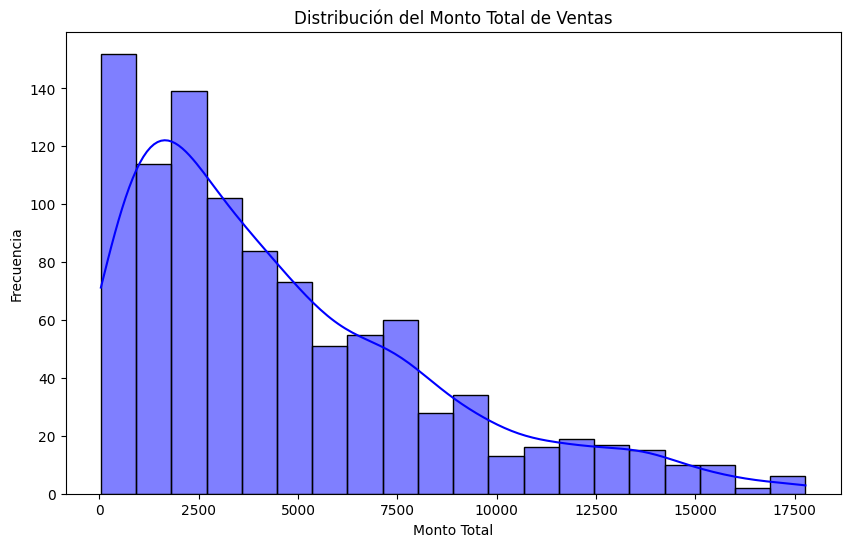

In [7]:
query_productos_ventas = """select ventas.productoid,productos.nombreproducto,ventas.cantidad
	from ventas 
inner join productos on productos.productoid = ventas.productoid"""

df_productos_ventas = pd.read_sql_query(query_productos_ventas, con=engine)

# Calcular la cantidad total vendida por producto
total_ventas_por_producto = df_productos_ventas.groupby('nombreproducto')['cantidad'].sum()

producto_mas_vendido = total_ventas_por_producto.idxmax()
cantidad_mas_vendida = total_ventas_por_producto.max()
# Obtener el producto menos vendido
producto_menos_vendido = total_ventas_por_producto.idxmin()
cantidad_menos_vendida = total_ventas_por_producto.min()

print(f"\nProducto más vendido: {producto_mas_vendido} con {cantidad_mas_vendida} unidades vendidas")
print(f"Producto menos vendido: {producto_menos_vendido} con {cantidad_menos_vendida} unidades vendidas")


df_ventas_monto = pd.read_sql_query("SELECT * FROM transacciones", engine)

# Calcular la distribución de las ventas (histograma) utilizando NumPy
sales_distribution, bin_edges = np.histogram(df_ventas_monto['montototal'], bins='auto')

# Crear un DataFrame para mostrar la distribución con encabezados
sales_distribution_df = pd.DataFrame({'Monto Total': bin_edges[:-1], 'Frecuencia': sales_distribution})
sales_distribution_df['Monto Total'] = sales_distribution_df['Monto Total'].round(2)

print("\nDistribución de las ventas(histograma):")
print(sales_distribution_df)


# Distribución del monto total de ventas
plt.figure(figsize=(10, 6))
sns.histplot(df_ventas["montototal"], kde=True, bins=20, color="blue")
plt.title("Distribución del Monto Total de Ventas")
plt.xlabel("Monto Total")
plt.ylabel("Frecuencia")
plt.show()

# 3.2 -  Identificación de Patrones, Tendencias y Anomalías

- Analiza las series temporales de ventas para identificar tendencias ascendentes o descendentes.
- Usa técnicas de agrupamiento para segmentar a los clientes según comportamiento de compra, detectando grupos clave (por ejemplo, clientes frecuentes vs. esporádicos).
- Identifica anomalías, como picos de ventas inusuales, productos que no se venden como se esperaba o clientes con comportamientos fuera de lo común.


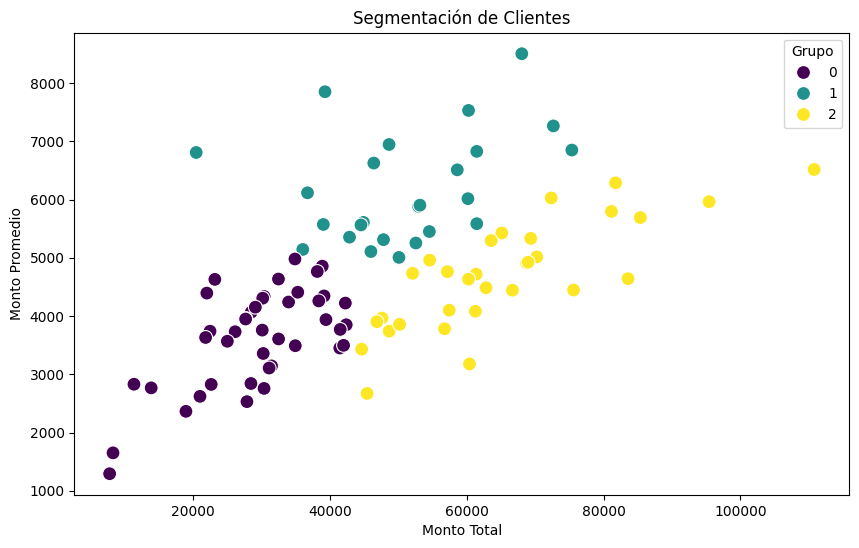

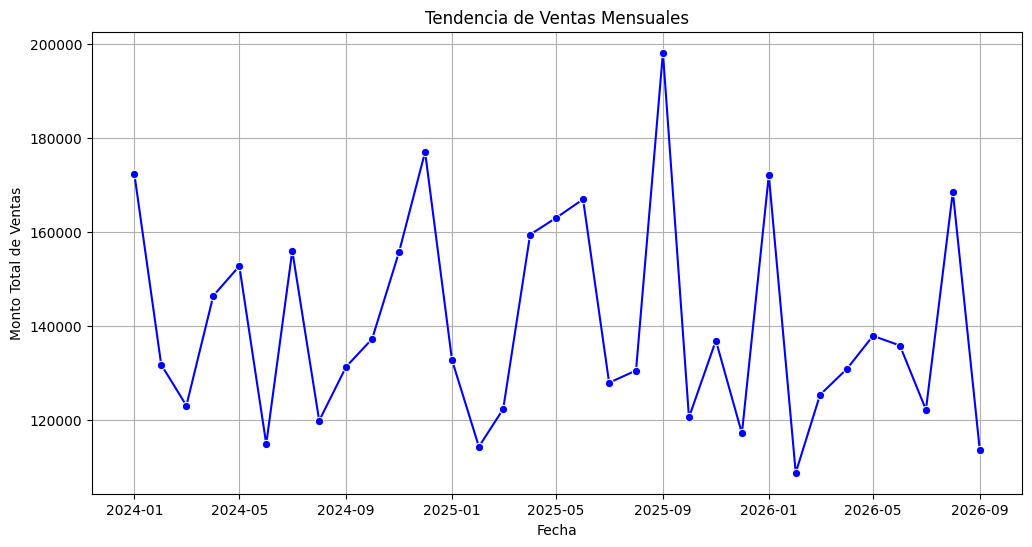

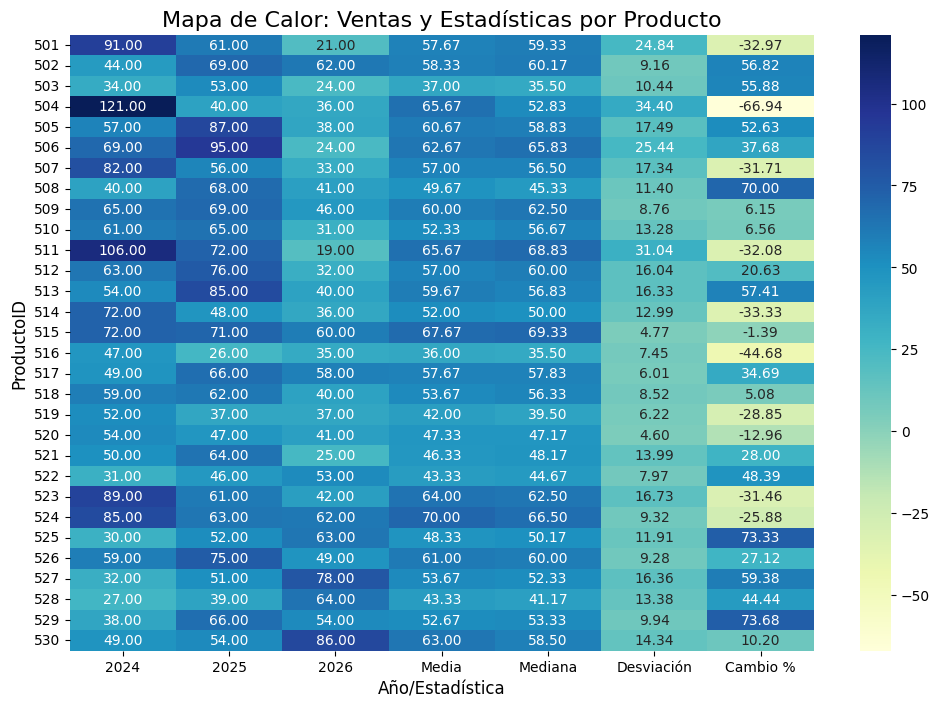

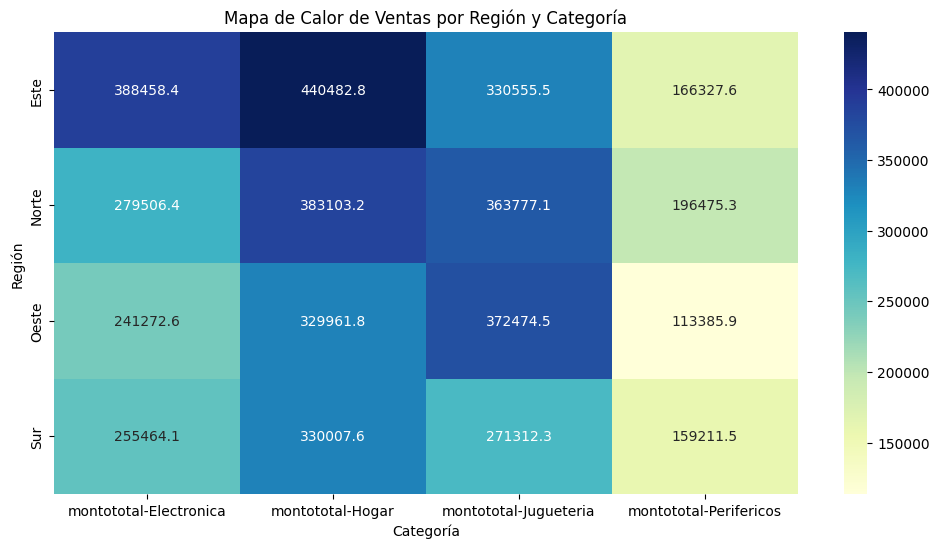

    clienteid  Total_Transacciones  Total_Compras TipoCliente
0        1001                   12             44   Frecuente
1        1002                   13             51   Frecuente
2        1003                    7             34    Moderado
3        1004                    7             42    Moderado
4        1005                   15             86   Frecuente
..        ...                  ...            ...         ...
95       1096                   12             61   Frecuente
96       1097                   11             50   Frecuente
97       1098                   10             62    Moderado
98       1099                   10             51    Moderado
99       1100                   10             49    Moderado

[100 rows x 4 columns]


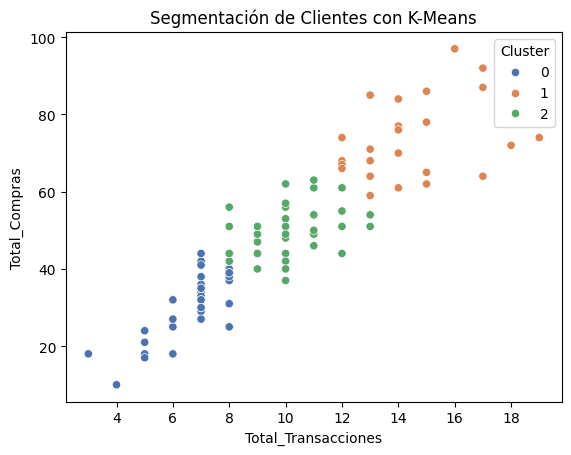

In [ ]:
# 1. Series temporales
df_ventas = pd.read_sql_table("ventas", con=engine)
df_ventas = df_ventas.merge(df_productos, on="productoid")
df_ventas = df_ventas.merge(df_transacciones, on="transaccionid")

# Conversión de fechas
df_ventas["fechaventa"] = pd.to_datetime(df_ventas["fechaventa"])
df_ventas["fechatransaccion"] = pd.to_datetime(df_ventas["fechatransaccion"])


ventas_por_mes = df_ventas.groupby(df_ventas["fechaventa"].dt.to_period("M")).agg(
    {"montototal": "sum"}
).reset_index()
ventas_por_mes["fechaventa"] = ventas_por_mes["fechaventa"].dt.to_timestamp()


# 2. Segmentación de clientes
scaler = StandardScaler()
clientes_normalizados = scaler.fit_transform(
    ventas_por_cliente[["montototal", "montopromedio", "transacciones"]]
)

kmeans = KMeans(n_clusters=3, random_state=42)
ventas_por_cliente["grupo"] = kmeans.fit_predict(clientes_normalizados)

# Visualización de clústeres
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=ventas_por_cliente,
    x="montototal",
    y="montopromedio",
    hue="grupo",
    palette="viridis",
    s=100,
)
plt.title("Segmentación de Clientes")
plt.xlabel("Monto Total")
plt.ylabel("Monto Promedio")
plt.legend(title="Grupo")
plt.show()


# Grafico - Tendencias en ventas mensuales con Matplotlib y Seaborn
plt.figure(figsize=(12, 6))
sns.lineplot(data=ventas_por_mes, x="fechaventa", y="montototal", marker="o", color="blue")
plt.title("Tendencia de Ventas Mensuales")
plt.xlabel("Fecha")
plt.ylabel("Monto Total de Ventas")
plt.grid(True)
plt.show()



ventas = pd.read_sql_query("SELECT * FROM ventas", engine)
# Asegurar que FechaVenta esté en formato datetime y extraer el año
ventas['fechaventa'] = pd.to_datetime(ventas['fechaventa'])
ventas['Año'] = ventas['fechaventa'].dt.year

# Crear una tabla pivote con la suma de las cantidades por ProductoID y Año
pivot_ventas = pd.pivot_table(
    ventas,
    values='cantidad',        # Cantidades vendidas
    index='productoid',       # Índice: Productos
    columns='Año',            # Columnas: Años
    aggfunc='sum',            # Sumar cantidades
    fill_value=0              # Rellenar valores faltantes con 0
)

# Calcular estadísticas adicionales
pivot_ventas['Media'] = pivot_ventas.mean(axis=1)      # Promedio de ventas por producto
pivot_ventas['Mediana'] = pivot_ventas.median(axis=1)  # Mediana de ventas por producto
pivot_ventas['Desviación'] = pivot_ventas.std(axis=1)  # Variabilidad de ventas por producto
if 2024 in pivot_ventas.columns and 2025 in pivot_ventas.columns:  # Verificar que ambos años existan
    pivot_ventas['Cambio %'] = ((pivot_ventas[2025] - pivot_ventas[2024]) / pivot_ventas[2024]) * 100

# Seleccionar las columnas para el mapa de calor
columns_to_plot = [2024, 2025, 2026, 'Media', 'Mediana', 'Desviación', 'Cambio %']

# Crear el mapa de calor
plt.figure(figsize=(12, 8))  # Tamaño del gráfico
sns.heatmap(
    pivot_ventas[columns_to_plot],  # Seleccionar columnas para el heatmap
    cmap='YlGnBu',                  # Paleta de colores
    annot=True,                     # Mostrar valores en las celdas
    fmt='.2f',                      # Formato de los valores
    cbar=True                       # Mostrar barra de color
)

# Agregar títulos
plt.title('Mapa de Calor: Ventas y Estadísticas por Producto', fontsize=16)
plt.xlabel('Año/Estadística', fontsize=12)
plt.ylabel('ProductoID', fontsize=12)

# Mostrar el gráfico
plt.show()


# Mapa de calor de ventas por región y categoría
ventas_por_region_categoria = df_ventas.groupby(["region", "categoria"]).agg(
    {"montototal": "sum"}
).unstack() 

plt.figure(figsize=(12, 6))
sns.heatmap(ventas_por_region_categoria, cmap="YlGnBu", annot=True, fmt=".1f")
plt.title("Mapa de Calor de Ventas por Región y Categoría")
plt.ylabel("Región")
plt.xlabel("Categoría")
plt.show()


# Analisis de los graficos
- ### **Segmentacion de clientes**:
- Grupo de Alto Valor (High Value) - Grupo 0.

Características: Clientes con alto Monto Total y alto Monto Promedio.
Insight: Estos clientes son los más valiosos y podrían ser el objetivo de programas de fidelización y ofertas exclusivas para mantener su lealtad.

- Grupo de Compradores Frecuentes:

Características: Clientes con alto Monto Total pero bajo Monto Promedio.
Insight: Estos clientes compran con frecuencia pero en pequeñas cantidades. Podrían beneficiarse de promociones que incentiven compras de mayor valor.

- Grupo de Compradores Ocasionales:

Características: Clientes con bajo Monto Total y bajo Monto Promedio.
Insight: Estos clientes compran esporádicamente y gastan poco. Estrategias de marketing podrían enfocarse en aumentar la frecuencia de sus compras y el valor de sus transacciones.


### **Tendencia de ventas mensuales**:
- Muestra cómo varía el monto total de ventas a lo largo del tiempo, mes a mes.
#### Tendencias Generales:

- Tendencia Ascendente: Si el gráfico muestra una línea ascendente, indica que las ventas están aumentando con el tiempo. Esto puede ser un signo de crecimiento del negocio, mayor aceptación de productos o servicios, o efectividad de las estrategias de marketing.
- Tendencia Descendente: Si la línea es descendente, sugiere una disminución en las ventas, lo que podría ser motivo de preocupación y requerir una revisión de las estrategias de negocio.

#### Estacionalidad:

- Picos y Valles: La presencia de picos y valles en ciertos meses puede indicar patrones estacionales. Por ejemplo, picos en diciembre podrían sugerir un aumento en las ventas debido a las festividades.

- Meses Consistentemente Altos/Bajos: Identificar meses que consistentemente muestran ventas altas o bajas puede ayudar a planificar inventarios y campañas de marketing.

#### Anomalías:

- Picos Inusuales: Un pico inusualmente alto en un mes específico puede indicar una promoción exitosa, lanzamiento de un nuevo producto, o un evento especial.

- Caídas Inusuales: Una caída significativa en las ventas puede señalar problemas como interrupciones en la cadena de suministro, cambios en la demanda del mercado, o problemas internos.

#### Comparación Año a Año:

- Crecimiento Interanual: Comparar las ventas de un mes con el mismo mes en años anteriores puede proporcionar una visión del crecimiento interanual.

- Patrones Recurrentes: Identificar patrones recurrentes año tras año puede ayudar a predecir futuros comportamientos de ventas.

### **Mapa de calor - Ventas y estadisticas por producto**:

- Muestra la relación entre diferentes productos y sus estadísticas de ventas utilizando una escala de colores. Aquí hay algunos puntos clave que podemos interpretar del gráfico:

#### Identificación de Productos Populares:

- Colores Intensos: Los productos con colores más intensos (por ejemplo, rojo o azul oscuro) indican un mayor volumen de ventas o estadísticas destacadas. Estos productos son los más populares y generan la mayor parte de los ingresos.

- Colores Suaves: Los productos con colores más suaves (por ejemplo, amarillo o azul claro) indican un menor volumen de ventas. Estos productos pueden necesitar estrategias de marketing adicionales para aumentar su popularidad.

#### Comparación entre Productos:

- Patrones de Ventas: Comparar los colores entre diferentes productos puede ayudar a identificar cuáles tienen un rendimiento superior o inferior. Esto puede ser útil para tomar decisiones sobre la gestión del inventario y la promoción de productos. - Segmentación de Productos: Los productos pueden ser segmentados en diferentes categorías según su rendimiento de ventas, lo que permite una mejor planificación y enfoque en los productos clave.

#### Detección de Anomalías:

- Productos con Ventas Inusuales: Si un producto muestra un color significativamente diferente al de otros productos en su categoría, puede ser una anomalía que requiere una investigación más profunda. Esto podría ser debido a una promoción especial, un problema de calidad, o cambios en la demanda del mercado.

#### Estrategias de Marketing y Promoción:

- Focalización de Esfuerzos: Los productos con ventas bajas pueden ser el objetivo de campañas de marketing específicas para aumentar su visibilidad y demanda.

- Promociones y Descuentos: Los productos con ventas altas pueden ser utilizados en promociones cruzadas para impulsar las ventas de productos menos populares.

#### Optimización del Inventario:

- Gestión de Stock: Los productos con altas ventas deben tener un inventario adecuado para evitar desabastecimientos, mientras que los productos con bajas ventas pueden necesitar ajustes en los niveles de stock para evitar sobreinventarios.

### **Mapa de calor - Ventas por region y categoria**:

#### Identificación de Regiones y Categorías Populares:

- Colores Intensos: Las celdas con colores más intensos (en este caso de amarillo claro como el menos intenso hasta azul oscuro como indicador mas intenso) indican un mayor volumen de ventas en esa combinación de región y categoría. Estas combinaciones son las más populares y generan la mayor parte de los ingresos.

- Colores Suaves: Las celdas con colores más suaves (por ejemplo, amarillo o azul claro) indican un menor volumen de ventas. Estas combinaciones pueden necesitar estrategias de marketing adicionales para aumentar su popularidad. 
#### Comparación entre Regiones y Categorías: 
- Patrones de Ventas: Comparar los colores entre diferentes regiones y categorías puede ayudar a identificar cuáles tienen un rendimiento superior o inferior. Esto puede ser útil para tomar decisiones sobre la gestión del inventario y la promoción de productos en diferentes regiones. 
- Segmentación de Mercados: Las regiones pueden ser segmentadas en diferentes categorías según su rendimiento de ventas, lo que permite una mejor planificación y enfoque en los mercados clave. 
#### Detección de Anomalías: 
- Regiones o Categorías con Ventas Inusuales: Si una región o categoría muestra un color significativamente diferente al de otras en su grupo, puede ser una anomalía que requiere una investigación más profunda. Esto podría ser debido a una promoción especial, un problema de calidad, o cambios en la demanda del mercado. 
#### Estrategias de Marketing y Promoción: 
- Focalización de Esfuerzos: Las combinaciones de región y categoría con ventas bajas pueden ser el objetivo de campañas de marketing específicas para aumentar su visibilidad y demanda. 
- Promociones y Descuentos: Las combinaciones con ventas altas pueden ser utilizadas en promociones cruzadas para impulsar las ventas de combinaciones menos populares. 
#### Optimización del Inventario: 
- Gestión de Stock: Las combinaciones de región y categoría con altas ventas deben tener un inventario adecuado para evitar desabastecimientos, mientras que las combinaciones con bajas ventas pueden necesitar ajustes en los niveles de stock para evitar sobreinventarios.
    